### Dell Technologies Proof of Concept - CHAT, ANALYZE AND GRAPH YOUR CSV DATA WITH MISTRAL LLM
- Model:  Mistral instruct v2
- Workload:  CSV analysis using LLM
- Orchestrator:  Langchain csv agent
- Dataset:  hospital visits

Note: The software and sample files are provided “as is” and are to be used only in conjunction with this POC application. They should not be used in production and are provided without warranty or guarantees. Please use them at your own discretion.
    

### Huggingface tools

You will need to at least log in once to get the hub for tools and the embedding model.  After that you can comment this section out.

In [1]:
## code to auto login to hugging face, avoid the login prompt
# %pip install huggingface-hub==0.16.4
%pip install --upgrade huggingface-hub

# get your account token from https://huggingface.co/settings/tokens
# this is a read-only test token

token = ''

from huggingface_hub import login
login(token=token, add_to_git_credential=True)

Note: you may need to restart the kernel to use updated packages.
Token is valid (permission: read).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/demouser/.cache/huggingface/token
Login successful


### Install python libraries and applications

Using % to ensure installation into this conda environment and not OS python

In [2]:
%pip install accelerate  ## for use of device map feature
%pip install transformers
%pip install langchain==0.1.7
%pip install langchain_experimental==0.0.51
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
### Check installed GPU

In [4]:
!nvidia-smi

Tue Feb 20 15:58:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:0D:00.0 Off |                    0 |
| N/A   47C    P0              83W / 350W |   1925MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Assign GPU environment vars and ID order

NOTE:  to change which GPU you want visible, simply change the CUDA VISIBLE DEVICES ID to the GPU you prefer. 
This method guarantees no confusion or misplaced workloads on any GPUs.

In [5]:
## THESE VARIABLES MUST APPEAR BEFORE TORCH OR CUDA IS IMPORTED
## set visible GPU devices and order of IDs to the PCI bus order
## target the L40s that is on ID 1

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"   

## this integer corresponds to the ID of the GPU, for multiple GPU use "0,1,2,3"...
## to disable all GPUs, simply put empty quotes ""

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

### Investigate our GPU and CUDA environment

NOTE:  If you are only using 1 single GPU in the visibility settings above, then the active CUDA device will always be 0 since it is the only GPU seen.

In [6]:
import torch
import sys
import os
from subprocess import call
print('_____Python, Pytorch, Cuda info____')
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA RUNTIME API VERSION')
#os.system('nvcc --version')
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('_____nvidia-smi GPU details____')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('_____Device assignments____')
print('Number CUDA Devices:', torch.cuda.device_count())
print ('Current cuda device: ', torch.cuda.current_device(), ' **May not correspond to nvidia-smi ID above, check visibility parameter')
print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

_____Python, Pytorch, Cuda info____
__Python VERSION: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
__pyTorch VERSION: 2.2.0
__CUDA RUNTIME API VERSION
__CUDNN VERSION: 8902
_____nvidia-smi GPU details____
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA H100 PCIe, 535.154.05, 81559 MiB, 1925 MiB, 79082 MiB
1, NVIDIA L40S, 535.154.05, 46068 MiB, 41538 MiB, 4057 MiB
_____Device assignments____
Number CUDA Devices: 1
Current cuda device:  0  **May not correspond to nvidia-smi ID above, check visibility parameter
Device name:  NVIDIA H100 PCIe


### Assign single GPU to device variable

This command assigns GPU ID 0 to the DEVICE variable called "cuda:0" if pytorch can actually reach and speak with the GPU using cuda language.  Else it will use the cpu.

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


### View csv contents and structure

In [8]:
import pandas as pd
df = pd.read_csv('csv-files/healthcare.csv')

In [9]:
df_rows = df.head(3)
print(df_rows)

  Patient Name Date of Birth  Age Reason for Admission       Procedure  \
0    Patient_3      8/6/2004   19                COVID  antiviral meds   
1   Patient_39     3/19/2004   19                COVID  oxygen therapy   
2   Patient_33     12/8/2002   21                COVID  oxygen therapy   

       Room Date of Discharge  Length of Stay   Charges  Balance Remaining  
0  Room_237        12/27/2023               0    237.34              37.34  
1  Room_440         1/12/2024              22  29980.84            3018.84  
2  Room_298        12/31/2023               6   4028.77            2681.26  


### Import CSV agent dependencies

In [10]:
import transformers
from langchain_experimental.agents.agent_toolkits import create_csv_agent
from langchain.llms import HuggingFacePipeline
from tqdm import tqdm
import time

In [11]:
# from langchain.globals import set_verbose, set_debug
# set_debug(True)
# set_verbose(True)

### Set model parameters

In [12]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

In [13]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

In [14]:
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    max_new_tokens=500
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
local_llm = HuggingFacePipeline(pipeline=pipeline)

### Initiate CSV agent

In [16]:
agent = create_csv_agent(
    local_llm,
    "csv-files/healthcare.csv",
    verbose=True,
#    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

### Generate responses

In [17]:
res = agent.invoke("What was the procedure for patient 3?")
print(res)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Thought: I need to find the row in the dataframe that corresponds to patient 3 and then extract the procedure column for that row.
Action: python_repl_ast
Action Input: df.loc[df['Patient Name'] == 'Patient_3', 'Procedure'].values[0]antiviral meds I now know the final answer
Final Answer: The procedure for patient 3 was antiviral meds.

> Finished chain.
{'input': 'What was the procedure for patient 3?', 'output': 'The procedure for patient 3 was antiviral meds.'}


##### Compare to correct answer:  antiviral meds

In [18]:
res = agent.invoke("What was date of discharge and length of stay for patient 21?")
print(res)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Thought: I need to find the row where the patient number is 21. Then I can extract the date of discharge and length of stay from that row.
Action: python_repl_ast
Action Input: df[df['Patient Name'] == 'Patient_21'].iloc[0]['Date of Discharge']11/15/2023

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 I also need to find the length of stay for patient 21.
Action: python_repl_ast
Action Input: df[df['Patient Name'] == 'Patient_21'].iloc[0]['Length of Stay']18 I now know the final answer.
Final Answer: The date of discharge for patient 21 was 11/15/2023 and the length of stay was 18 days.

> Finished chain.
{'input': 'What was date of discharge and length of stay for patient 21?', 'output': 'The date of discharge for patient 21 was 11/15/2023 and the length of stay was 18 days.'}


##### Compare to correct answer:  11/15/2023 and the length of stay was 18 days

In [19]:
res = agent.invoke("What are the unique reasons for admission?")
print(res)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Thought: I need to find the unique reasons for admission from the dataframe.
Action: python_repl_ast
Action Input: df['Reason for Admission'].unique()['COVID' 'Flu' 'Pneumonia' 'Heart attack' 'Stroke'] I now know the final answer.
Final Answer: ['COVID', 'Flu', 'Pneumonia', 'Heart attack', 'Stroke']

> Finished chain.
{'input': 'What are the unique reasons for admission?', 'output': "['COVID', 'Flu', 'Pneumonia', 'Heart attack', 'Stroke']"}


##### Compare to correct answer:  COVID', 'Flu', 'Pneumonia', 'Heart attack', 'Stroke

In [20]:
res = agent.invoke("Cross reference the charges with the reason for admission to determine which reason had the highest cost.")
print(res)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Thought: I need to group the dataframe by the reason for admission and then find the maximum charges for each group.
Action: python_repl_ast
Action Input: df.groupby('Reason for Admission')['Charges'].max()Reason for Admission
COVID           29980.84
Flu              9890.30
Heart attack    15440.26
Pneumonia        7820.46
Stroke           8475.26
Name: Charges, dtype: float64 I now know the final answer.
Final Answer: The reason for admission with the highest cost was COVID, with a total cost of 29,980.84.

> Finished chain.
{'input': 'Cross reference the charges with the reason for admission to determine which reason had the highest cost.', 'output': 'The reason for admission with the highest cost was COVID, with a total cost of 29,980.84.'}


##### Correct answer:  highest cost was COVID, with a total cost of 29980.84

In [21]:
res = agent.invoke("What are the top three most costly procedures?")
print(res)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


/home/demouser/miniconda3/envs/csv/lib/python3.10/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Thought: I need to find the top three most costly procedures in the dataframe.
Action: df.groupby('Procedure')['Charges'].sum().nlargest(3)
Action Input:df.groupby('Procedure')['Charges'].sum().nlargest(3) is not a valid tool, try one of [python_repl_ast].

/home/demouser/miniconda3/envs/csv/lib/python3.10/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 I need to use the pandas library to find the top three most costly procedures.
Action: python_repl_ast
Action Input: df.groupby('Procedure')['Charges'].sum().nlargest(3)Procedure
oxygen therapy    112456.32
bypass surgery     32999.17
clot removal       23949.17
Name: Charges, dtype: float64 I now know the final answer.
Final Answer: The top three most costly procedures are 'oxygen therapy', 'bypass surgery', and 'clot removal'.

> Finished chain.
{'input': 'What are the top three most costly procedures?', 'output': "The top three most costly procedures are 'oxygen therapy', 'bypass surgery', and 'clot removal'."}


##### Correct answer:  most costly procedures are 'oxygen therapy', 'bypass surgery', and 'clot removal'

### Create visualizations of data using LLM and matplotlib

/home/demouser/miniconda3/envs/csv/lib/python3.10/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


/home/demouser/miniconda3/envs/csv/lib/python3.10/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Thought: I need to use pandas to extract the age column and then use matplotlib to plot a histogram.
Action: python_repl_ast
Action Input: import matplotlib.pyplot as plt; df['Age'].hist()Axes(0.125,0.11;0.775x0.77)

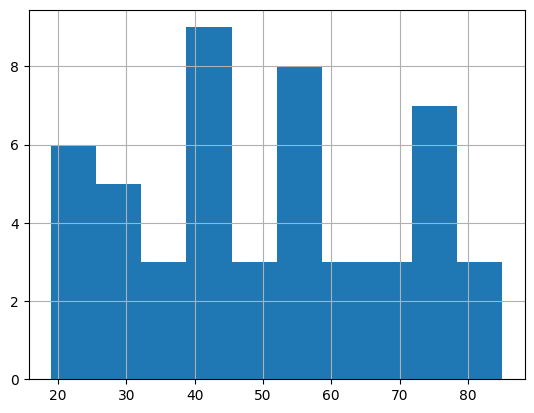

/home/demouser/miniconda3/envs/csv/lib/python3.10/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 I need to display the plot.
Action: python_repl_ast
Action Input: plt.show() I now know the final answer
Final Answer: The histogram of age distribution of the patients is displayed.

> Finished chain.
{'input': 'Plot a histogram of age distribution of the patients.', 'output': 'The histogram of age distribution of the patients is displayed.'}


In [25]:
res = agent.invoke("Plot a histogram of the age distribution of the patients.")
print(res)

/home/demouser/miniconda3/envs/csv/lib/python3.10/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new AgentExecutor chain...


/home/demouser/miniconda3/envs/csv/lib/python3.10/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Thought: I need to use the value_counts() method to count the number of occurrences of each procedure, and then normalize those counts to percentages. After that, I can use matplotlib to create a pie chart.
Action: python_repl_ast
Action Input: df['Procedure'].value_counts().sort_index().div(df['Procedure'].value_counts().sum()).reset_index().rename(columns={'index': 'Procedure', 'Procedure': 'Percentage'}).to_dict('records')[{'Percentage': 'angioplasty', 'count': 0.08}, {'Percentage': 'antibiotics', 'count': 0.06}, {'Percentage': 'antiviral meds', 'count': 0.26}, {'Percentage': 'bypass surgery', 'count': 0.06}, {'Percentage': 'clot removal', 'count': 0.08}, {'Percentage': 'dialysis', 'count': 0.06}, {'Percentage': 'imaging', 'count': 0.02}, {'Percentage': 'oxygen therapy', 'count': 0.28}, {'Percentage': 'rehab', 'count': 0.04}, {'Percentage': 'ventilator', 'count': 0.06}]

/home/demouser/miniconda3/envs/csv/lib/python3.10/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Now that I have the data in a dictionary, I can use matplotlib to create the pie chart.
Action: python_repl_ast
Action Input: import matplotlib.pyplot as plt; labels = [x['Procedure'] for x in data]; sizes = [x['count'] for x in data]; plt.pie(sizes, labels=labels, autopct='%1.1f%%')NameError: name 'data' is not defined

/home/demouser/miniconda3/envs/csv/lib/python3.10/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 I forgot to assign the dictionary to a variable.
Action: python_repl_ast
Action Input: data = [{'Percentage': 'angioplasty', 'count': 0.08}, {'Percentage': 'antibiotics', 'count': 0.06}, {'Percentage': 'antiviral meds', 'count': 0.26}, {'Percentage': 'bypass surgery', 'count': 0.06}, {'Percentage': 'clot removal', 'count': 0.08}, {'Percentage': 'dialysis', 'count': 0.06}, {'Percentage': 'imaging', 'count': 0.02}, {'Percentage': 'oxygen therapy', 'count': 0.28}, {'Percentage':'rehab', 'count': 0.04}, {'Percentage':'ventilator', 'count': 0.06}]

/home/demouser/miniconda3/envs/csv/lib/python3.10/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Now that I have the data in a variable, I can create the pie chart.
Action: python_repl_ast
Action Input: plt.pie( [x['count'] for x in data], labels=[x['Percentage'] for x in data], autopct='%1.1f%%')([<matplotlib.patches.Wedge object at 0x7fce8823bee0>, <matplotlib.patches.Wedge object at 0x7fce8823be20>, <matplotlib.patches.Wedge object at 0x7fce8828cc10>, <matplotlib.patches.Wedge object at 0x7fce8828d2a0>, <matplotlib.patches.Wedge object at 0x7fce8828d930>, <matplotlib.patches.Wedge object at 0x7fce8828dfc0>, <matplotlib.patches.Wedge object at 0x7fce8828e650>, <matplotlib.patches.Wedge object at 0x7fce8828ece0>, <matplotlib.patches.Wedge object at 0x7fce8828f370>, <matplotlib.patches.Wedge object at 0x7fce8828fa00>], [Text(1.0654414787782402, 0.27355886989611045, 'angioplasty'), Text(0.8475645778852774, 0.7011663756300295, 'antibiotics'), Text(-0.1378665027667493, 1.0913261782871637, 'antiviral meds'), Text(-0.9953097184661809, 0.46835730412450277, 'bypass surgery'), Text(-1.09

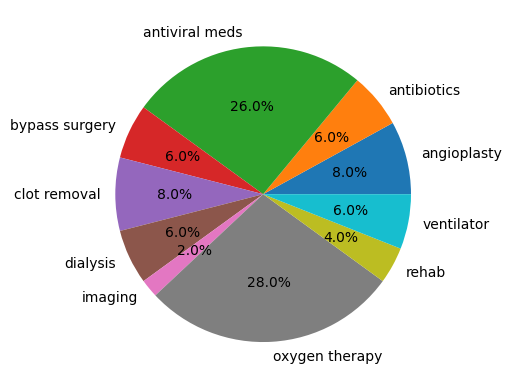

In [26]:
res = agent.invoke("Plot a pie chart of the number of procedures based on percentage.")
print(res)

### Print conda environment and versions

In [24]:
!conda env export --name csv | grep -v "^prefix: "

name: csv
channels:
  - pytorch
  - nvidia
  - conda-forge
dependencies:
  - _libgcc_mutex=0.1=conda_forge
  - _openmp_mutex=4.5=2_kmp_llvm
  - asttokens=2.4.1=pyhd8ed1ab_0
  - blas=2.116=mkl
  - blas-devel=3.9.0=16_linux64_mkl
  - brotli-python=1.1.0=py310hc6cd4ac_1
  - bzip2=1.0.8=hd590300_5
  - ca-certificates=2024.2.2=hbcca054_0
  - certifi=2024.2.2=pyhd8ed1ab_0
  - charset-normalizer=3.3.2=pyhd8ed1ab_0
  - comm=0.2.1=pyhd8ed1ab_0
  - cuda-cudart=12.1.105=0
  - cuda-cupti=12.1.105=0
  - cuda-libraries=12.1.0=0
  - cuda-nvrtc=12.1.105=0
  - cuda-nvtx=12.1.105=0
  - cuda-opencl=12.3.101=0
  - cuda-runtime=12.1.0=0
  - debugpy=1.8.1=py310hc6cd4ac_0
  - decorator=5.1.1=pyhd8ed1ab_0
  - exceptiongroup=1.2.0=pyhd8ed1ab_2
  - executing=2.0.1=pyhd8ed1ab_0
  - ffmpeg=4.3=hf484d3e_0
  - filelock=3.13.1=pyhd8ed1ab_0
  - freetype=2.12.1=h267a509_2
  - gmp=6.3.0=h59595ed_0
  - gmpy2=2.1.2=py310h3ec546c_1
  - gnutls=3.6.13=h85f3911_1
  - icu=73.2=h59595ed_0
  - idna=3.6=pyhd8ed1ab_0
  - importli

##### Author:  David O'Dell, Dell Technologies Tech Marketing Engineer, Data Solutions and AI
Inspiration code:  https://python.langchain.com/docs/integrations/toolkits/csv
